In [2]:
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, zscore, pearsonr, wilcoxon
import pybedtools as pbt
from scipy.integrate import simps
from IPython.display import clear_output
from ipyparallel import Client

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

# DVIEW = Client()[:]
# DVIEW.block=True
# len(DVIEW)

In [2]:
def fetch_promoter_g4s_wrapper(chrom, loop):
    import pybedtools as pbt
    
    def fetch_promoter_g4s(g4_bed, promoter_bed):
        g4s = []
        intersect = promoter_bed.intersect(g4_bed, wo=True)
        unique_starts = {}
        for i in intersect:
            c = str(i).split('\t')
            if c[7] not in unique_starts:
                if c[11][0].upper() == 'G':
                    if c[5] == '+':
                        strand = 'sense'
                    else:
                        strand = 'antisense'
                else:
                    if c[5] == '-':
                        strand = 'sense'
                    else:
                        strand = 'antisense'
                g4s.append("\t".join(c[6:9] + [strand]))
                unique_starts[c[7]] = 1
        return pbt.BedTool('\n'.join(g4s), from_string=True)
    
    con_quad_dir = '/home/parashar/scratch/quadruplexes/hg19'
    tss_dir = '/home/parashar/scratch/quadcomb/data/annotation/chrom_wise_gencode_tss'
    out_dir = '/home/parashar/scratch/quadruplexes/hg19_promoter_g4'
    gene_info = '/home/parashar/scratch/hg19_resource/hg19.genome'
    for bulge in [0, 5]:
        g4_fn = "%s/g3_%d_%d_%s_nov.bed" % (con_quad_dir, loop, bulge, chrom)
        tss_fn = "%s/%s.bed" % (tss_dir, chrom)
        g4_bed = pbt.BedTool(g4_fn)
        promoter_bed = pbt.BedTool(tss_fn).slop(b=1000, g=gene_info)
        promoter_g4s = fetch_promoter_g4s(g4_bed, promoter_bed)
        promoter_g4s.saveas("%s/g3_%d_%d_%s_nov.bed" % (out_dir, loop, bulge, chrom))
    return True

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
for loop in tqdm([10, 15, 25]):
    DVIEW.map_sync(fetch_promoter_g4s_wrapper, chroms,
                                  [loop for x in range(len(chroms))])

100%|██████████| 3/3 [01:02<00:00, 20.60s/it]


In [3]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

### Okay, first thing to do here is to get information on TSS arranged by strand and chromosomes

In [4]:
gene_tss_info = {'positive': {}, 'negative': {}}
for chrom in chroms:
    gene_tss_info['positive'][chrom] = []
    gene_tss_info['negative'][chrom] = []
    with open('../data/annotation/chrom_wise_gencode_tss/%s.bed' % chrom) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            up = int(c[1]) - 1000
            down = int(c[1]) + 1000 + 1
            if c[5] == '+':
                gene_tss_info['positive'][chrom].append((up, down, c[3]))
            else:
                gene_tss_info['negative'][chrom].append((up, down, c[3]))

In [5]:
utr5_info = {'positive': {}, 'negative': {}}
for chrom in chroms:
    utr5_info['positive'][chrom] = []
    utr5_info['negative'][chrom] = []
    with open('../data/annotation/chrom_wise_genocode_utr_5/%s.bed' % chrom) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            up = int(c[1]) - 1000
            down = int(c[1]) + 1000 + 1
            if c[5] == '+':
                utr5_info['positive'][chrom].append((up, down, c[3]))
            else:
                utr5_info['negative'][chrom].append((up, down, c[3]))

### Lets load the expectation array in each of the promoter region and save it to a numpy. This is a 2D array array of shape (no. of promoters, +/- regions around TSS)

In [5]:
def load_scores(chrom, strand):
    in_dir = '/home/parashar/scratch/quadcomb/data/snipr'
    fn = '%s/%s_%s_scores.npy' % (in_dir, chrom, strand)
    return np.load(fn, mmap_mode='r')
    
gene_sense_exp = []
gene_antisense_exp = []
for strand, opp_strand in zip(['positive', 'negative'], ['negative', 'positive']):
    for chrom in tqdm(chroms, desc=strand):
        exp_scores = load_scores(chrom, strand)
        for i in gene_tss_info[strand][chrom]:
            if strand == 'positive':
                gene_sense_exp.append(exp_scores[i[0]:i[1]])
            else:
                gene_sense_exp.append(exp_scores[i[0]:i[1]][::-1])
        for i in gene_tss_info[opp_strand][chrom]:
            if opp_strand == 'positive':
                gene_antisense_exp.append(exp_scores[i[0]:i[1]])
            else:
                gene_antisense_exp.append(exp_scores[i[0]:i[1]][::-1])
    clear_output()

np.save('../data/gene_arrays/snipr_sense', np.array(gene_sense_exp))
np.save('../data/gene_arrays/snipr_antisense', np.array(gene_antisense_exp))

### Now lets also calculate the G content in the promoters

In [ ]:
for strand, base, inv_base in zip(['positive', 'negative'], ['G', 'C'], ['C', 'G']):
    gene_array_g_content = []
    for chrom in tqdm(chroms):
        g_comp = np.zeros(chrom_info[chrom])
        fasta = '/home/parashar/scratch/hg19_resource/chromosomes/%s.fa' % chrom
        seq = "".join([x.rstrip('\n') for x in open(fasta).readlines()[1:]])
        for i in gene_tss_info[strand][chrom]:
            a = list(map(int, seq[i[0]:i[1]].upper().replace('A', '0').replace(
            'T', '0').replace('N', '0').replace(inv_base, '0').replace(base, '1')))
            gene_array_g_content.append(a)
    np.save('./data/gene_arrays/g_comp_%s' % strand, np.array(gene_array_g_content))

### Now also save the G4 motifs in the same promoter regions

In [37]:
con_quad_dir = '/home/parashar/scratch/quadruplexes/hg19'

for loop in [10, 15, 25]:
    for bulge in [0, 5]:
        g4_motif_sense = []
        g4_motif_antisense = []
        for strand, opp_strand, base in zip(
            ['positive', 'negative'], ['negative', 'positive'], ['G', 'C']):    
            for chrom in tqdm(chroms, desc="%d_%d_%s" % (loop, bulge, strand)):
                chrom_array = np.zeros(chrom_info[chrom])
                fn = '%s/g3_%d_%d_%s_ov.bed' % (con_quad_dir, loop, bulge, chrom)
                with open(fn) as h:
                    for l in h:
                        c = l.split('\t')
                        if c[0] == chrom and c[4][0] == base:
                            chrom_array[int(c[1]):int(c[2])] += 1
                for i in gene_tss_info[strand][chrom]:
                    if strand == 'positive':
                        g4_motif_sense.append(chrom_array[i[0]:i[1]])
                    else:
                        g4_motif_sense.append(chrom_array[i[0]:i[1]][::-1])
                for i in gene_tss_info[opp_strand][chrom]:
                    if opp_strand == 'positive':
                        g4_motif_antisense.append(chrom_array[i[0]:i[1]])
                    else:
                        g4_motif_antisense.append(chrom_array[i[0]:i[1]][::-1])
        np.save('../data/gene_arrays/g3_%d_%d_sense' % (loop, bulge),
                np.array(g4_motif_sense))
        np.save('../data/gene_arrays/g3_%d_%d_antisense' % (loop, bulge),
                np.array(g4_motif_antisense))
        clear_output()

### We will also check out the TSS distribution of OQs

In [13]:
oq_sense = []
oq_antisense = []
for strandsymb, opp_strand, strand in zip(['+', '-'],
                                          ['negative', 'positive'], ['positive', 'negative']):
    for chrom in chroms:
        region_bed_file = "./data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom
        chrom_array = np.zeros(chrom_info[chrom])
        with open(region_bed_file) as h:
            for l in tqdm(h, desc="%s %s" % (chrom, strandsymb)):
                c = l.rstrip('\n').split('\t')
                if c[3] == strandsymb:
                    chrom_array[int(c[1]): int(c[2])] = 1
        for i in gene_tss_info[strand][chrom]:
            if strand == 'positive':
                oq_antisense.append(chrom_array[i[0]:i[1]])
            else:
                oq_antisense.append(chrom_array[i[0]:i[1]][::-1])
        for i in gene_tss_info[opp_strand][chrom]:
            if opp_strand == 'positive':
                oq_sense.append(chrom_array[i[0]:i[1]])
            else:
                oq_sense.append(chrom_array[i[0]:i[1]][::-1])
        clear_output()
np.save('./data/gene_arrays/K2_oq_sense', np.array(oq_sense))
np.save('./data/gene_arrays/K2_oq_antisense', np.array(oq_antisense))

In [5]:
oq_utr = []
for strandsymb, opp_strand, strand in zip(['+', '-'],
                                          ['negative', 'positive'], ['positive', 'negative']):
    for chrom in chroms:
        region_bed_file = "./data/ROC_data/regions/chrom_wise/Na_K_2_oq_regions_%s.bed" % chrom
        chrom_array = np.zeros(chrom_info[chrom])
        with open(region_bed_file) as h:
            for l in tqdm(h, desc="%s %s" % (chrom, strandsymb)):
                c = l.rstrip('\n').split('\t')
                if c[3] == strandsymb:
                    chrom_array[int(c[1]): int(c[2])] = 1
        for i in utr5_info[opp_strand][chrom]:
            if opp_strand == 'positive':
                oq_utr.append(chrom_array[i[0]:i[1]])
            else:
                oq_utr.append(chrom_array[i[0]:i[1]][::-1])
        clear_output()
oq_utr = np.array(oq_utr)

### Time to plot

In [11]:
gene_array_oq = {}
gene_array_exp = {}
for orient in ['sense', 'antisense']:
    gene_array_oq[orient] = np.load('../data/gene_arrays/K2_oq_%s.npy' % orient)
    gene_array_exp[orient] = np.load('../data/gene_arrays/snipr_%s.npy' % orient)

In [12]:
len(gene_array_exp['antisense'])

200015

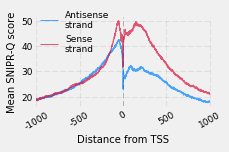

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 2.2))

a = gene_array_exp['antisense']
ax.plot(a.mean(axis=0), c='dodgerblue', lw=1, alpha=0.8, label='Antisense\nstrand')
a = gene_array_exp['sense']
ax.plot(a.mean(axis=0), c='crimson', lw=1, alpha=0.7, label='Sense\nstrand')

ax.axvline(1000, lw=0.5, ls='--', c='k', alpha=0.4)
ax.legend(frameon=False, fontsize=9, loc=(0, 0.55))
ax.set_ylabel('Mean SNIPR-Q score', fontsize=10)
ax.set_xlabel('Distance from TSS', fontsize=10)
ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
ax.set_xlim((0, 2010))
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/promoter_all_snipr_scores.svg',
            transparent=True, edgecolor='none')
plt.show()

(200015, 2001) (19312,)
(200015, 2001) (16466,)


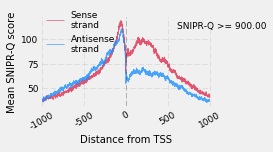

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 2.2))

max_y = 0
cutoff = 900

a = gene_array_exp['sense']
idx = np.where((a.max(axis=1) > cutoff))[0]
print (a.shape, idx.shape)
snipr = a[idx, :].mean(axis=0)
ax.plot(snipr, c='crimson', lw=0.7, alpha=0.7, label='Sense\nstrand')

a = gene_array_exp['antisense']
idx = np.where((a.max(axis=1) > cutoff))[0]
print (a.shape, idx.shape)
snipr = a[idx, :].mean(axis=0)
ax.plot(snipr, c='dodgerblue', lw=0.7, alpha=0.8, label='Antisense\nstrand')

ax.axvline(1000, lw=0.5, ls='--', c='k', alpha=0.4)
ax.legend(frameon=False, fontsize=9, loc=(0, 0.55))
ax.set_ylabel('Mean SNIPR-Q score', fontsize=10)
ax.set_xlabel('Distance from TSS', fontsize=10)
ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
ax.set_xlim((0, 2010))
ax.text(0.8, 0.87, 'SNIPR-Q >= %.2f' % cutoff, fontsize=9, transform=ax.transAxes)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/promoter_high_snipr_scores.svg',
            transparent=True, edgecolor='none')
plt.show()

(200015, 2001) (11507,)
(200015, 2001) (14062,)


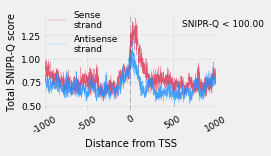

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 2.3))
max_y = 0
cutoff  = 100
a = gene_array_exp['sense']
idx = np.where((a.max(axis=1) < cutoff))[0]
snipr = a[idx, :].mean(axis=0)
print (a.shape, idx.shape)
ax.plot(snipr, c='crimson', lw=0.3, alpha=0.7, label='Sense\nstrand')

a = gene_array_exp['antisense']
idx = np.where((a.max(axis=1) < cutoff))[0]
print (a.shape, idx.shape)
snipr = a[idx, :].mean(axis=0)
ax.plot(snipr, c='dodgerblue', lw=0.3, alpha=0.8, label='Antisense\nstrand')

ax.axvline(1000, lw=0.5, ls='--', c='k', alpha=0.4)
ax.legend(frameon=False, fontsize=9, loc=(0, 0.55))
ax.set_ylabel('Total SNIPR-Q score', fontsize=10)
ax.set_xlabel('Distance from TSS', fontsize=10)
ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
ax.set_xlim((0, 2010))
ax.text(0.8, 0.87, 'SNIPR-Q < %.2f' % cutoff, fontsize=9, transform=ax.transAxes)
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/promoter_low_snipr_scores.svg', transparent=True, edgecolor='none')
plt.show()

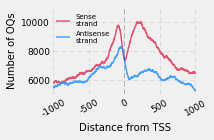

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(3.2, 2.2))

ax.plot(gene_array_oq['sense'].sum(axis=0), c='crimson',
        lw=1.5, alpha=0.7, label='Sense\nstrand')
ax.plot(gene_array_oq['antisense'].sum(axis=0), c='dodgerblue',
        lw=1.5, alpha=0.8, label='Antisense\nstrand')
max_y = max(gene_array_oq['sense'].sum(axis=0).max(),
            gene_array_oq['antisense'].sum(axis=0).max())

ax.axvline(1000, lw=0.5, ls='--', c='k', alpha=0.4)
ax.legend(frameon=False, fontsize=7, loc=(0, 0.55))
ax.set_ylabel('Number of OQs', fontsize=10)
ax.set_xlabel('Distance from TSS', fontsize=10)
ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
ax.set_xlim((0, 2010))
ax.set_ylim((5000, max_y + 0.1 * max_y))
clean_axis(ax)

plt.tight_layout()
plt.savefig('../images/promoter_OQs.svg', transparent=True, edgecolor='none')
plt.show()

In [21]:
len(np.where(gene_array_oq['sense'].sum(axis=1) > 0)[0]), len(np.where(gene_array_oq['antisense'].sum(axis=1) > 0)[0])

(108772, 100777)

In [31]:
gene_array_g4 = {}
for orient in ['sense', 'antisense']:
    gene_array_g4[orient] = {}
    for loop in [25]:
        for bulge in [5]:
            gene_array_g4[orient]["%d_%d" % (loop, bulge)] = np.load(
                '../data/gene_arrays/g3_%s_%s_%s.npy' % (loop, bulge, orient))

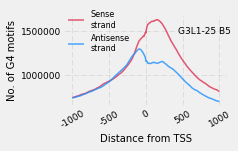

In [35]:
loops_bulges = [[25, 5]]

for lb in loops_bulges:
    max_y = 0
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.2))
    
    a = gene_array_g4['sense']["%d_%d" % (lb[0], lb[1])]
    ax.plot((a.sum(axis=0)), lw=1.5, alpha=0.7,
            color='crimson', label='Sense\nstrand')
    #max_y = max(max_y, a.sum(axis=0).max())
    
    a = gene_array_g4['antisense']["%d_%d" % (lb[0], lb[1])]
    ax.plot((a.sum(axis=0)), lw=1.5, alpha=0.8,
            color='dodgerblue', label='Antisense\nstrand')
    #max_y = max(max_y, a.sum(axis=0).max())
    
    ax.set_ylabel('No. of G4 motifs', fontsize=10)
    ax.set_xlabel('Distance from TSS', fontsize=10)
    ax.set_xticks([0, 500, 1000, 1500, 2000])
    ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=30)
    ax.legend(frameon=False, loc=(0, 0.55), fontsize=8, ncol=1)
    ax.text(0.7, 0.8, "G3L1-%d B%d" % (lb[0], lb[1]), fontsize=9, transform=ax.transAxes)
    #ax.set_ylim((0, max_y + 0.1 * max_y))
    clean_axis(ax)
    
    plt.tight_layout()
    plt.savefig('../images/promoter_motifs_%d_%d.svg' % (lb[0], lb[1]),
                transparent=True, edgecolor='none')
    plt.show()